LightGBM : 이상거래 예측

목표: 카드 거래 내역 데이터셋을 이용해 이상거래를 예측

via 최효원's Jupyter Notebook

이상거래는 카드값을 지불하지 않을 의도를 가지고서 결제를 하거나,
도난된 카드를 가지고 결제를 하는 등의 거래를 의미합니다.
종속변수(target) 는 이상거래 여부이고, 독립변수는 거래 시간, 고객 성별, 상점 범주 등이 있습니다.

리프 중심 트리 분할 방식을 사용하고, XGBoost 이후로 나온 최신 부스팅 모델인 LightGBM 을
해당 작업에 적용했습니다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('https://media.githubusercontent.com/media/musthave-ML10/data_source/main/fraud.csv')
#데이터 출처 : https://media.githubusercontent.com/media/musthave-ML10
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [3]:
df.info(show_counts = True)
#total : 1852394 rows / 22 cols
#결측치 없음

#trans_date_trans_time : 거래 시간
#cc_num : 카드 번호(고윳값, id 로 활용 가능)
#merchant : 거래 상점
#category : 거래 상점의 범주(애완용품, 여행, 엔터테인먼트 등)
#amt : 거래 금액
#first / last : 이름
#gender : 성별
#street / state / zip : 고객 거주지 정보
#lat / long : 고객 주소에 대한 위도 / 경도
#city_pop : 고객 zipcode 에 속하는 인구 수
#job : 직업
#dob : 생년월일
#trans_num : 거래번호
#unix_time : 거래 시간(unix 타임스탬프 형식)
#merch_lat / merch_long : 상점 위치에 대한 위도 / 경도

#is_fraud : 사기거래 여부(종속변수, target)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1852394 non-null  object 
 1   cc_num                 1852394 non-null  int64  
 2   merchant               1852394 non-null  object 
 3   category               1852394 non-null  object 
 4   amt                    1852394 non-null  float64
 5   first                  1852394 non-null  object 
 6   last                   1852394 non-null  object 
 7   gender                 1852394 non-null  object 
 8   street                 1852394 non-null  object 
 9   city                   1852394 non-null  object 
 10  state                  1852394 non-null  object 
 11  zip                    1852394 non-null  int64  
 12  lat                    1852394 non-null  float64
 13  long                   1852394 non-null  float64
 14  city_pop          

In [3]:
round(df.describe(), 2)
#통계 정보 확인

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.852394e+06,1852394.00,1852394.00,1852394.00,1852394.00,1852394.00,1.852394e+06,1852394.00,1852394.00,1852394.00
mean,4.173860e+17,70.06,48813.26,38.54,-90.23,88643.67,1.358674e+09,38.54,-90.23,0.01
std,1.309115e+18,159.25,26881.85,5.07,13.75,301487.62,1.819508e+07,5.11,13.76,0.07
min,6.041621e+10,1.00,1257.00,20.03,-165.67,23.00,1.325376e+09,19.03,-166.67,0.00
25%,1.800429e+14,9.64,26237.00,34.67,-96.80,741.00,1.343017e+09,34.74,-96.90,0.00
50%,3.521417e+15,47.45,48174.00,39.35,-87.48,2443.00,1.357089e+09,39.37,-87.44,0.00
75%,4.642255e+15,83.10,72042.00,41.94,-80.16,20328.00,1.374581e+09,41.96,-80.25,0.00
max,4.992346e+18,28948.90,99921.00,66.69,-67.95,2906700.00,1.388534e+09,67.51,-66.95,1.00


*amt(거래 금액) / city_pop(고객 zipcode 속하는 인구수)  : max 값이 급격히 높아져 outlier 를 의심해볼 수 있지만,
변수 특성상 충분히 일어날 수 있으므로 별도의 처리 작업은 하지 않을 예정입니다.
*is_fraud(target) 의 mean 이 0.01 로 매우 낮습니다(imbalanced data). 이는 만들어진 모델 정확도가 99% 여도 성능이 좋은 모델이라 보장할 수 없습니다. 오버샘플링 작업을 통해 모델의 예측 정확도를 높일 예정입니다.

In [6]:
#이상거래 탐지에 불필요하다 생각하는 변수 제거

df.drop(['first','last','city','state','zip','trans_num','unix_time','job','merchant'],\
       axis = 1, inplace = True)
#first / last : 이름 정보
#city / state / zip : 위도와 경도 정보가 따로 있어 제거
#trans_num : id 정보(거래 번호, 고윳값)
#unix_time : trans_date_trans_time 정보를 사용할 예정이므로 제거
#job / merchant : category 변수로 대체

In [7]:
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
#날짜 형식으로 변환

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 13 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   trans_date_trans_time  datetime64[ns]
 1   cc_num                 int64         
 2   category               object        
 3   amt                    float64       
 4   gender                 object        
 5   street                 object        
 6   lat                    float64       
 7   long                   float64       
 8   city_pop               int64         
 9   dob                    object        
 10  merch_lat              float64       
 11  merch_long             float64       
 12  is_fraud               int64         
dtypes: datetime64[ns](1), float64(5), int64(3), object(4)
memory usage: 183.7+ MB


* Feature Engineering

In [9]:
#amt(거래량)
#평소 소비 패턴 대비 이상 금액을 찾기 위해 Z-score(표준 점수) 사용

amt_info = df.groupby('cc_num').agg(['mean','std'])['amt'].reset_index()
#cc_num 별 amt 평균 및 표준편차 계산
amt_info.head()

,cc_num,mean,std
0,60416207185,59.257796,142.869746
1,60422928733,65.483159,92.042844
2,60423098130,96.376084,1000.693872
3,60427851591,107.487550,131.014534
4,60487002085,64.096925,153.207660


In [10]:
df = df.merge(amt_info, on = 'cc_num', how = 'left')
#생성한 데이터 left join

#Z-score 계산 후 변수 추가
df['amt_z_score'] = (df['amt'] - df['mean'])/df['std']

In [11]:
df[['amt','mean','std','amt_z_score']].head()

,amt,mean,std,amt_z_score
0,4.97,89.408743,127.530101,-0.662108
1,107.23,56.078113,159.201852,0.321302
2,220.11,69.924272,116.688602,1.287064
3,45.00,80.090040,280.077880,-0.125287
4,41.96,95.341146,94.322842,-0.565941


*2행 값에서 평균 거래 금액이 $69.92 수준인데 해당 지출 금액은 $220 로 상당한 차이를 보입니다.

In [12]:
df.drop(['mean','std'], axis = 1, inplace = True)
#Z-score 외의 변수 제거

In [13]:
#category - 거래 상점의 범주(애완용품, 여행, 엔터테인먼트 등)
#각 개인마다 어떤 범주에서 얼만큼의 금액을 쓰는지 또한 다르므로, cc_num / category 에 대한 Z-score 계산

category_info = df.groupby(['cc_num','category']).agg(['mean','std'])['amt'].reset_index()

In [14]:
df = df.merge(category_info, on = ['cc_num','category'], how = 'left')

In [15]:
df['cat_z_score'] = (df['amt'] - df['mean']) / df['std']
#Z-score 변수 추가
df.drop(['mean', 'std'], axis = 1, inplace = True)
#제거

In [17]:
#고객 위치와 상점의 위치(둘 사이의 거리 계산, Z-score 활용)
#ex.) 고객이 주로 주소지 부근 100km 반경에서만 거래하다가,
#3,000km 떨어진 지역에서 거래가 발생했다면, 이상거래를 의심할 여지가 있습니다.

import geopy.distance
#두 지점 거리 계산에 필요한 geopy library import
#geopy.distance.distance 모듈 : 두 지점에 대한 위도와 경도를 튜플 형태로 받아서 계산

df['merch_coord'] = pd.Series(zip(df['merch_lat'], df['merch_long']))
#상점의 위도와 경도를 한 변수로 합치기
df['cust_coord'] = pd.Series(zip(df['lat'], df['long']))
#고객 주소지의 위도와 경도를 한 변수로 합치기

In [18]:
df['distance'] = df.apply(lambda x: geopy.distance.distance(x['merch_coord'], x['cust_coord']).km\
                         , axis = 1)
#거리 계산

In [19]:
#상점 위치, 고객 주소지 사이 거리에 대한 Z-score 계산

distance_info = df.groupby('cc_num').agg(['mean','std'])['distance'].reset_index()
#cc_num 별 거리 정보 계산(mean, std)
df = df.merge(distance_info, on = 'cc_num', how = 'left')
df['distance_z_score'] = (df['distance'] - df['mean']) / df['std']
#Z-score 계산 후 새로운 변수 추가
df.drop(['mean','std'], axis = 1, inplace = True)
#이외 변수 제거
df.head()

,trans_date_trans_time,cc_num,category,amt,gender,street,lat,long,city_pop,dob,merch_lat,merch_long,is_fraud,amt_z_score,cat_z_score,merch_coord,cust_coord,distance,distance_z_score
0,2019-01-01 00:00:18,2703186189652095,misc_net,4.97,F,561 Perry Cove,36.0788,-81.1781,3495,1988-03-09,36.011293,-82.048315,0,-0.662108,-0.688297,"(36.011293, -82.048315)","(36.0788, -81.1781)",78.773821,0.030974
1,2019-01-01 00:00:44,630423337322,grocery_pos,107.23,F,43039 Riley Greens Suite 393,48.8878,-118.2105,149,1978-06-21,49.159047,-118.186462,0,0.321302,0.317631,"(49.159047, -118.186462)","(48.8878, -118.2105)",30.216618,-1.475224
2,2019-01-01 00:00:51,38859492057661,entertainment,220.11,M,594 White Dale Suite 530,42.1808,-112.2620,4154,1962-01-19,43.150704,-112.154481,0,1.287064,2.872509,"(43.150704, -112.154481)","(42.1808, -112.262)",108.102912,1.160572
3,2019-01-01 00:01:16,3534093764340240,gas_transport,45.00,M,9443 Cynthia Court Apt. 038,46.2306,-112.1138,1939,1967-01-12,47.034331,-112.561071,0,-0.125287,-1.050197,"(47.034331, -112.561071)","(46.2306, -112.1138)",95.685115,0.818063
4,2019-01-01 00:03:06,375534208663984,misc_pos,41.96,M,408 Bradley Rest,38.4207,-79.4629,99,1986-03-28,38.674999,-78.632459,0,-0.565941,1.312866,"(38.674999, -78.632459)","(38.4207, -79.4629)",77.702395,0.064037


In [20]:
#age(나이)
#dob(생년월일) 데이터를 datetime 을 활용해 나이를 계산

df['age'] = 2021 - pd.to_datetime(df['dob']).dt.year

In [21]:
df.drop(['cc_num','lat','long','merch_lat','merch_long','dob','merch_coord','cust_coord'],\
       axis = 1, inplace = True)
#feature engineering 작업 후 불필요 변수 제거
df.head()

,trans_date_trans_time,category,amt,gender,street,city_pop,is_fraud,amt_z_score,cat_z_score,distance,distance_z_score,age
0,2019-01-01 00:00:18,misc_net,4.97,F,561 Perry Cove,3495,0,-0.662108,-0.688297,78.773821,0.030974,33
1,2019-01-01 00:00:44,grocery_pos,107.23,F,43039 Riley Greens Suite 393,149,0,0.321302,0.317631,30.216618,-1.475224,43
2,2019-01-01 00:00:51,entertainment,220.11,M,594 White Dale Suite 530,4154,0,1.287064,2.872509,108.102912,1.160572,59
3,2019-01-01 00:01:16,gas_transport,45.00,M,9443 Cynthia Court Apt. 038,1939,0,-0.125287,-1.050197,95.685115,0.818063,54
4,2019-01-01 00:03:06,misc_pos,41.96,M,408 Bradley Rest,99,0,-0.565941,1.312866,77.702395,0.064037,35


In [23]:
df = pd.get_dummies(df, columns = ['category', 'gender'], drop_first = True)
#남아있는 object 변수 더미 처리

In [24]:
#trans_date_trans_time : 예측에는 불필요하나, 훈련/테스트셋 분할에 사용하기 위해 인덱스 처리

df.set_index('trans_date_trans_time', inplace = True)
df.head()

,amt,street,city_pop,is_fraud,amt_z_score,cat_z_score,distance,distance_z_score,age,category_food_dining,...,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_M
trans_date_trans_time,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:18,4.97,561 Perry Cove,3495,0,-0.662108,-0.688297,78.773821,0.030974,33,0,...,0,0,0,1,0,0,0,0,0,0
2019-01-01 00:00:44,107.23,43039 Riley Greens Suite 393,149,0,0.321302,0.317631,30.216618,-1.475224,43,0,...,0,0,0,0,0,0,0,0,0,0
2019-01-01 00:00:51,220.11,594 White Dale Suite 530,4154,0,1.287064,2.872509,108.102912,1.160572,59,0,...,0,0,0,0,0,0,0,0,0,1
2019-01-01 00:01:16,45.00,9443 Cynthia Court Apt. 038,1939,0,-0.125287,-1.050197,95.685115,0.818063,54,0,...,0,0,0,0,0,0,0,0,0,1
2019-01-01 00:03:06,41.96,408 Bradley Rest,99,0,-0.565941,1.312866,77.702395,0.064037,35,0,...,0,0,0,0,1,0,0,0,0,1


In [30]:
df.drop('street', axis = 1, inplace = True)

* Modeling

*지금까지 발생한 거래 데이터를 기반으로 모델을 학습시키고, 모델을 활용해 앞으로 일어나는 거래에 대한 이상 여부를 예측.
*train_test_split 을 사용하지 않고, 특정 날짜를 기준으로 훈련과 시험셋을 분할했습니다.

In [31]:
train = df[df.index < '2020-07-01']
#훈련셋
test = df[df.index >= '2020-07-01']
#시험셋

len(test)/len(df)
#시험셋 비율 확인

0.2837738623640543

In [32]:
xtr = train.drop('is_fraud', axis = 1)
#x_train
xt = test.drop('is_fraud', axis = 1)
#x_test
ytr = train['is_fraud']
#y_train
yt = test['is_fraud']
#y_test

In [33]:
import lightgbm as lgb
#LightGBM import

md1 = lgb.LGBMClassifier(random_state = 100)
md1.fit(xtr, ytr)
#학습
pred1 = md1.predict(xt)
#예측1

In [34]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

accuracy_score(yt, pred1)
#정확도 확인

0.9970798670626126

*종속 변수 구성이 한쪽으로 치우친 imbalanced data 이기 때문에, 높은 정확도를 보입니다.

In [35]:
print(confusion_matrix(yt, pred1))

[[522935    714]
 [   821   1191]]


*2종 오류가 821 건으로, 821 건의 이상거래를 잡아내지 못했습니다.
*714 건의 정상 거래 건이 이상거래 건으로 잘못 감지됐습니다(1종 오류).

In [36]:
print(classification_report(yt, pred1))
#분류 리포트 확인

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    523649
           1       0.63      0.59      0.61      2012

    accuracy                           1.00    525661
   macro avg       0.81      0.80      0.80    525661
weighted avg       1.00      1.00      1.00    525661



*정상 거래를 한 고객이 확인 절차를 거치는 불편함이 조금 더 발생하더라도, 이상거래를 조금 더 포착하는게 중요합니다(예민하게 반응하는 모델).
*즉, 실제 이상거래(1) 를 얼마나 많이 예측하는지 의미하는 재현율(recall, 0.59) 수치가 precision(0.63) 수치보다 중요합니다.

In [37]:
proba1 = md1.predict_proba(xt)
#이진 분류가 아닌, 확률 형태로 예측
proba1

array([[9.99968780e-01, 3.12200192e-05],
       [9.99973950e-01, 2.60503805e-05],
       [9.99960796e-01, 3.92036839e-05],
       ...,
       [9.99964825e-01, 3.51745939e-05],
       [9.99844073e-01, 1.55926901e-04],
       [9.99945924e-01, 5.40758219e-05]])

In [38]:
proba1 = proba1[:,1]
#1에 대한 예측 결과만 분리

In [39]:
proba_int1 = (proba1 > 0.2).astype('int')
#0.2 확률 초과 시 1(이상거래), 비교적 예민한 반응
proba_int2 = (proba1 > 0.8).astype('int')
#0.8 확률 초과 시 1(이상거래), 비교적 둔감한 반응

In [40]:
#비교적 예민한 반응 모델에 대한 분류 리포트
print(confusion_matrix(yt, proba_int1))

[[522107   1542]
 [   598   1414]]


In [41]:
print(classification_report(yt, proba_int1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    523649
           1       0.48      0.70      0.57      2012

    accuracy                           1.00    525661
   macro avg       0.74      0.85      0.78    525661
weighted avg       1.00      1.00      1.00    525661



*재현율(recall) 수치가 0.7 로 확연히 개선된 모습을 보였습니다.
*정밀도(precision) 가 지나치게 낮아지는 것 또한 조심해야 하기 때문에, 적절한 기준점을 잡아야합니다.

In [42]:
#비교적 둔감한 반응 모델에 대한 분류 리포트
print(confusion_matrix(yt, proba_int2))

[[523185    464]
 [   958   1054]]


In [43]:
print(classification_report(yt, proba_int2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    523649
           1       0.69      0.52      0.60      2012

    accuracy                           1.00    525661
   macro avg       0.85      0.76      0.80    525661
weighted avg       1.00      1.00      1.00    525661



In [46]:
#roc_auc_score 확인

roc_auc_score(yt, proba1)

0.9366034338664935

*0.8 이상이면 높은 편이지만, 이 점수 또한 종속변수가 한 쪽으로 편향돼있을 때, 자연스럽게 높게 나오는 경향이 있습니다.

In [52]:
#LightGBM 의 train() 함수 사용
#검증셋(validation) 을 함께 사용하고, 특정 metrics 를 기준으로 평가하며 개선해나갑니다.

train = df[df.index < '2020-01-01']
#훈련셋 설정, 2019년 1월 ~ 2019년 12월
val = df[(df.index >= '2020-01-01')&(df.index < '2020-07-01')]
#검증셋 설정, 2020년 1월 ~ 2020년 6월
test = df[df.index >= '2020-07-01']
#시험셋 설정, 2020년 7월 ~ 2020년 12월

In [54]:
xtr = train.drop('is_fraud', axis = 1)
#x_train
xval = val.drop('is_fraud', axis = 1)
#x_val
xt = test.drop('is_fraud', axis = 1)
#x_test
ytr = train['is_fraud']
#y_train
yval = val['is_fraud']
#y_val
yt = test['is_fraud']
#y_test

In [55]:
#LightGBM 에서 제시하는 고유한 데이터셋 형태로 변환

d_train = lgb.Dataset(xtr, label = ytr)
#훈련셋
d_val = lgb.Dataset(xval, label = yval)
#검증셋

In [56]:
#하이퍼파라미터 튜닝 작업 후, 가장 좋은 성능을 보인 셋 변수 생성

best = {
    'n_estimators':1000,
    #반복 횟수
    'learning_rate':0.05,
    #학습률
    'lambda_l1': 0,
    #L1 정규화
    'lambda_l2':20,
    #L2 정규화
    'max_depth':15,
    #최대 깊이
    'subsample':1
    #서브 샘플 비율
}

In [57]:
params_set = best
#최적 파라미터 설정
params_set['metrics'] = 'auc'
#평가 기준 추가

In [58]:
params_set

{'n_estimators': 1000,
 'learning_rate': 0.05,
 'lambda_l1': 0,
 'lambda_l2': 20,
 'max_depth': 15,
 'subsample': 1,
 'metrics': 'auc'}

In [59]:
md3 = lgb.train(params_set, d_train, valid_sets = [d_val],\
               early_stopping_rounds = 100\
                #학습 시간 제한
                , verbose_eval = 100)
                #출력물을 특정 간격으로 보여줌

/Users/hyosasiburi/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/hyosasiburi/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/hyosasiburi/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018827 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1633
[LightGBM] [Info] Number of data points in the train set: 924850, number of used features: 21
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.005644
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.97237
[200]	valid_0's auc: 0.988574
[300]	valid_0's auc: 0.993031
[400]	valid_0's auc: 0.992582
Early stopping, bes

*327번째 트리에서 가장 좋은 auc 를 보여주었고, 이 뒤로 100 개 트리를 더 시도했으나 개선되지 않아 작업을 멈췄습니다.

In [60]:
pred3 = md3.predict(xt)
#개선된 모델을 활용한 예측

In [61]:
roc_auc_score(yt, pred3)
#개선된 모델의 roc_auc_score 확인

0.991352108964131

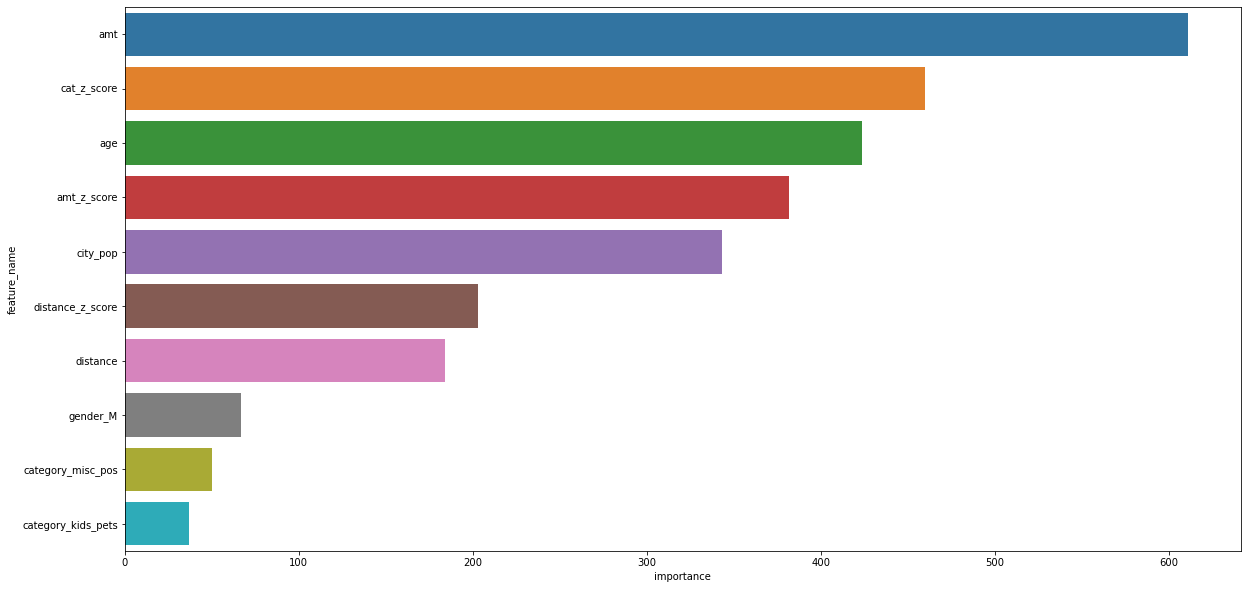

In [65]:
#중요 변수 정리 및 시각화

feature_imp_3 = pd.DataFrame(sorted(zip(md3.feature_importance(), xtr.columns)),\
                            columns = ['Value', 'Feature'])
plt.figure(figsize = (20,10))
sns.barplot(x = 'importance', y = 'feature_name', data = feature_imp.head(10))
plt.show()